In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

Test on cifar 10 with a fully convolutional network.

In [2]:
from fastai.conv_learner import *
PATH = Path("../data/cifar10/")

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [4]:
def get_data(sz,bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

In [5]:
size = 32
batch_size = 64

In [6]:
data = get_data(size,batch_size)

Convolutional block that is going to be the basic brick of the network.

In [7]:
def ConvBlock(ch_in, ch_out, ks = 3, stride=1, padding=1, re=True, bn=True):
    layers = [nn.Conv2d(ch_in,ch_out,ks,stride=stride,padding=1, bias=False)]
    if bn: layers.append(nn.BatchNorm2d(ch_out))
    if re: layers.append(nn.ReLU(inplace=True))
    return nn.Sequential(*layers)

Model

In [8]:
layers = [ConvBlock(3,64), 
          ConvBlock(64,64,stride=2), #size 16x16
          ConvBlock(64,128,stride=2), #size 8x8
          ConvBlock(128,256,stride=2), #size 4x4
          ConvBlock(256,10, stride=2), #size 2x2 
          nn.AdaptiveAvgPool2d(1), 
          Flatten()]
model = nn.Sequential(*layers)

In [9]:
learn = ConvLearner.from_model_data(model, data)
learn.crit = F.cross_entropy
learn.opt_fn = optim.Adam

In [10]:
learn.save('init')

## L2 regularization

We'll compare the results with a weight decay of 1e-3, first let's find a good learning rate.

In [12]:
learn.lr_find(wds=1e-3)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      2.328581   2.702632   0.0552    



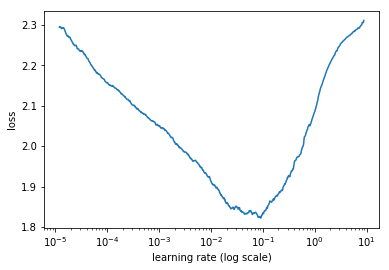

In [13]:
learn.sched.plot()

A good learning rate seems to be 1e-2 (usual rule of the thumb taking one tenth of the minimum). Now let's fit the model, by using cosine annealing with restarts.

In [14]:
learn.load('init')
learn.fit(1e-2, 3, cycle_len=2, cycle_mult=2, wds=1e-3)

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      1.366973   1.362556   0.5107    
    1      1.050072   0.952089   0.6766                                                                                
    2      1.24498    1.343065   0.5323                                                                                
    3      1.139381   1.012356   0.6512                                                                                
    4      1.011691   0.913163   0.6804                                                                                
    5      0.903516   0.825363   0.7144                                                                                
    6      1.168248   1.134538   0.6022                                                                                
    7      1.155694   1.070804   0.6231                                                                             

[0.725510502910614, 0.7565]

Let's try with a different value of weight decay.

In [17]:
learn.load('init')
learn.lr_find(wds=1e-4)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      2.228122   2.302627   0.0916    



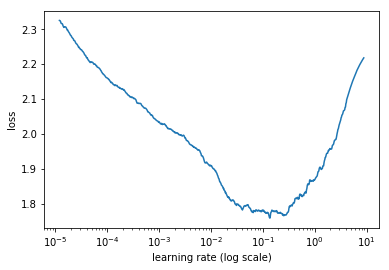

In [18]:
learn.sched.plot()

In [22]:
learn.fit(3e-2, 3, cycle_len=2, cycle_mult=2, wds=1e-4)

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      1.364093   1.283421   0.5476    
    1      1.035864   0.931432   0.6769                                                                                
    2      1.249609   1.233601   0.5634                                                                                
    3      1.11286    1.055653   0.6262                                                                                
    4      0.970532   0.884618   0.6926                                                                                
    5      0.867908   0.785878   0.7257                                                                                
    6      1.150543   1.438016   0.5453                                                                                
    7      1.14172    1.099656   0.613                                                                              

[0.7211050360679626, 0.7473]

Even if this weight decay lets us start with a higher learning rate, it doesn't fare as well in the end.

# Weight decay

Now let's try the weight decay outside of the loss.

In [24]:
learn.load('init')
learn.lr_find(wds=1e-3, use_wd_sched=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      2.031228   3.509109   0.1501    



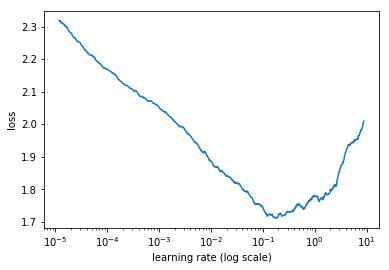

In [25]:
learn.sched.plot()

In [26]:
learn.load('init')
learn.fit(3e-2, 3, cycle_len=2, cycle_mult=2, wds=1e-3, use_wd_sched=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      1.24785    1.221652   0.5744    
    1      1.019789   0.913278   0.6814                                                                                
    2      1.067022   1.009697   0.6441                                                                                
    3      0.911696   0.901598   0.6892                                                                                
    4      0.818032   0.717331   0.7457                                                                                
    5      0.756188   0.664731   0.7684                                                                                
    6      0.887827   0.864669   0.7022                                                                                
    7      0.808763   0.719138   0.7457                                                                             

[0.5096985272407532, 0.8236]

That's a big jump from 75.65% accuracy! Let's see how a different value fares.

In [27]:
learn.load('init')
learn.lr_find(wds=1e-4, use_wd_sched=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      1.919752   3.22406    0.2505    



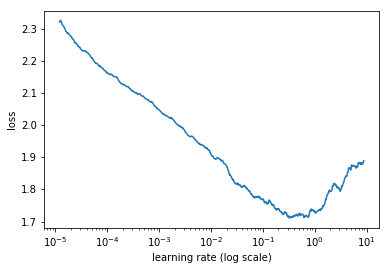

In [28]:
learn.sched.plot()

In [29]:
learn.fit(5e-2, 3, cycle_len=2, cycle_mult=2, wds=1e-4, use_wd_sched=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      1.303191   1.264462   0.5503    
    1      1.058796   0.933183   0.6718                                                                                
    2      1.085366   1.034799   0.6391                                                                                
    3      0.967457   0.838278   0.7011                                                                                
    4      0.839933   0.735207   0.7375                                                                                
    5      0.762747   0.690964   0.7588                                                                                
    6      0.897617   0.810663   0.7195                                                                                
    7      0.834577   0.786815   0.7271                                                                             

[0.5399318599700927, 0.8134]

1e-4 is a bit less performant, but still beating L2 reg.